In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pybamm

2025-12-23 23:12:57.479 - [WARNING] simulation.solve(557): Ignoring t_eval as solution times are specified by the experiment


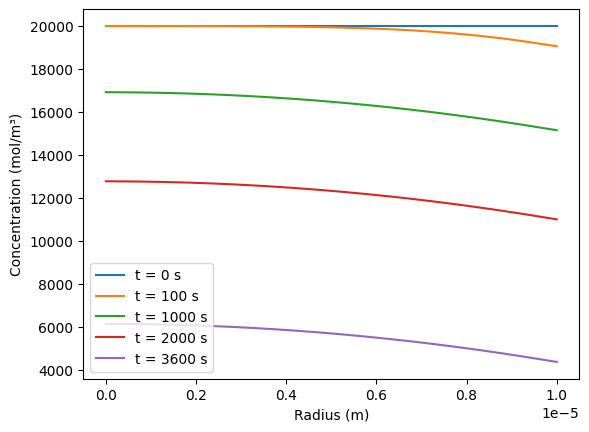

In [27]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

model = pybamm.lithium_ion.SPM()
experiment = pybamm.Experiment(["Discharge at 1C for 1 hour"])
sim = pybamm.Simulation(model, experiment)
sim.solve([0, 3600])

# Get processed variable
c = sim.solution["Negative particle concentration [mol.m-3]"]
r_var = sim.solution["Negative particle radius [m]"]

# Extract ONE radial grid (first particle)
r = r_var.entries[:, 0]   # <-- SINGLE particle, 1D array
r_surface = r[-1]

# r-values for plotting
r_plot = np.linspace(0, r_surface, 100)

# Extract ONLY the first domain (no duplicates)
def single_curve(t):
    val = c(t=t, r=r_plot)       # shape (100, 1)
    return val[:, 0]             # pick the first curve ONLY

# Evaluate curves
c_t0    = single_curve(0)
c_t100  = single_curve(100)
c_t1000 = single_curve(1000)
c_t2000 = single_curve(2000)
c_t3600 = single_curve(3600)

# Plot single clean lines
plt.plot(r_plot, c_t0,    label="t = 0 s")
plt.plot(r_plot, c_t100,  label="t = 100 s")
plt.plot(r_plot, c_t1000, label="t = 1000 s")
plt.plot(r_plot, c_t2000, label="t = 2000 s")
plt.plot(r_plot, c_t3600, label="t = 3600 s")

plt.xlabel("Radius (m)")
plt.ylabel("Concentration (mol/m³)")
plt.legend()
plt.show()



In [108]:
def SOCtoVoltage(soc):
  ocv_experiment = pybamm.Experiment([
        f"Rest for 5 minutes"])
  parameter_values = pybamm.ParameterValues("Chen2020")
  sim = pybamm.Simulation(model, experiment=ocv_experiment, parameter_values=parameter_values)
  sim.solve(initial_soc=soc)
  ocv = list(sim.solution['Voltage [V]'].entries)[0]
  return ocv



In [109]:
soc_vals = np.linspace(0.05, 0.95, 100)
ocv_vals = []
for soc in soc_vals:
    voltage = SOCtoVoltage(soc)
    ocv_vals.append(voltage)
    print(f"SOC: {soc:.2f}, OCV: {voltage:.4f} V")
ocv_vals = np.array(ocv_vals)

SOC: 0.05, OCV: 3.1094 V
SOC: 0.06, OCV: 3.1515 V
SOC: 0.07, OCV: 3.1867 V
SOC: 0.08, OCV: 3.2184 V
SOC: 0.09, OCV: 3.2490 V
SOC: 0.10, OCV: 3.2801 V
SOC: 0.10, OCV: 3.3118 V
SOC: 0.11, OCV: 3.3431 V
SOC: 0.12, OCV: 3.3720 V
SOC: 0.13, OCV: 3.3971 V
SOC: 0.14, OCV: 3.4176 V
SOC: 0.15, OCV: 3.4339 V
SOC: 0.16, OCV: 3.4468 V
SOC: 0.17, OCV: 3.4573 V
SOC: 0.18, OCV: 3.4662 V
SOC: 0.19, OCV: 3.4741 V
SOC: 0.20, OCV: 3.4816 V
SOC: 0.20, OCV: 3.4888 V
SOC: 0.21, OCV: 3.4961 V
SOC: 0.22, OCV: 3.5036 V
SOC: 0.23, OCV: 3.5115 V
SOC: 0.24, OCV: 3.5198 V
SOC: 0.25, OCV: 3.5286 V
SOC: 0.26, OCV: 3.5377 V
SOC: 0.27, OCV: 3.5472 V
SOC: 0.28, OCV: 3.5569 V
SOC: 0.29, OCV: 3.5668 V
SOC: 0.30, OCV: 3.5766 V
SOC: 0.30, OCV: 3.5862 V
SOC: 0.31, OCV: 3.5956 V
SOC: 0.32, OCV: 3.6046 V
SOC: 0.33, OCV: 3.6132 V
SOC: 0.34, OCV: 3.6213 V
SOC: 0.35, OCV: 3.6290 V
SOC: 0.36, OCV: 3.6364 V
SOC: 0.37, OCV: 3.6435 V
SOC: 0.38, OCV: 3.6504 V
SOC: 0.39, OCV: 3.6571 V
SOC: 0.40, OCV: 3.6637 V
SOC: 0.40, OCV: 3.6703 V


In [110]:
import torch  
import torch.nn as nn

In [128]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

In [ ]:

from sklearn.model_selection import train_test_split
import torch.optim as optim   # <-- REQUIRED FIX


X_train, X_test, y_train, y_test = train_test_split(
    soc_vals.reshape(-1, 1),
    ocv_vals.reshape(-1, 1),
    test_size=0.2,
    random_state=42
)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
soc_mean = X_train_tensor.mean()
soc_std = X_train_tensor.std()

ocv_mean = y_train_tensor.mean()
ocv_std = y_train_tensor.std()

X_train_tensor = (X_train_tensor - soc_mean) / soc_std
y_train_tensor = (y_train_tensor - ocv_mean) / ocv_std


train_model = SimpleNN()
optimizer = optim.Adam(train_model.parameters(), lr=1e-4)  # <-- FIXED
criterion = nn.MSELoss()


In [136]:
print(X_train_tensor)
print(y_train_tensor)

tensor([[ 0.1463],
        [ 1.2822],
        [-0.8519],
        [-0.3012],
        [ 0.6282],
        [-1.2306],
        [-0.3700],
        [ 1.5576],
        [-1.4371],
        [ 0.7315],
        [-1.3683],
        [-0.1291],
        [ 1.1790],
        [-0.7831],
        [ 1.4543],
        [-1.5748],
        [ 0.5249],
        [ 0.4905],
        [-0.5421],
        [-1.1962],
        [-0.0602],
        [-0.5766],
        [-1.5060],
        [ 1.5232],
        [-0.8175],
        [-1.0929],
        [ 1.0413],
        [-0.8864],
        [ 0.3872],
        [-1.2994],
        [-0.9208],
        [-1.6437],
        [-1.1617],
        [-0.4389],
        [-1.4715],
        [ 0.9380],
        [-1.5404],
        [ 0.4561],
        [-0.5077],
        [ 1.3166],
        [ 0.1807],
        [ 1.6609],
        [ 0.1119],
        [-0.2668],
        [-0.0258],
        [ 0.5594],
        [-0.1635],
        [ 0.5938],
        [ 0.3528],
        [ 1.5920],
        [ 0.9724],
        [-0.3356],
        [ 0.

In [137]:
for epoch in range(2000):
    train_model.train()
    optimizer.zero_grad()
    outputs = train_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/1000], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.0236
Epoch [200/1000], Loss: 0.0137
Epoch [300/1000], Loss: 0.0081
Epoch [400/1000], Loss: 0.0048
Epoch [500/1000], Loss: 0.0027
Epoch [600/1000], Loss: 0.0016
Epoch [700/1000], Loss: 0.0011
Epoch [800/1000], Loss: 0.0008
Epoch [900/1000], Loss: 0.0006
Epoch [1000/1000], Loss: 0.0005
Epoch [1100/1000], Loss: 0.0004
Epoch [1200/1000], Loss: 0.0004
Epoch [1300/1000], Loss: 0.0004
Epoch [1400/1000], Loss: 0.0003
Epoch [1500/1000], Loss: 0.0003
Epoch [1600/1000], Loss: 0.0003
Epoch [1700/1000], Loss: 0.0002
Epoch [1800/1000], Loss: 0.0002
Epoch [1900/1000], Loss: 0.0002
Epoch [2000/1000], Loss: 0.0002


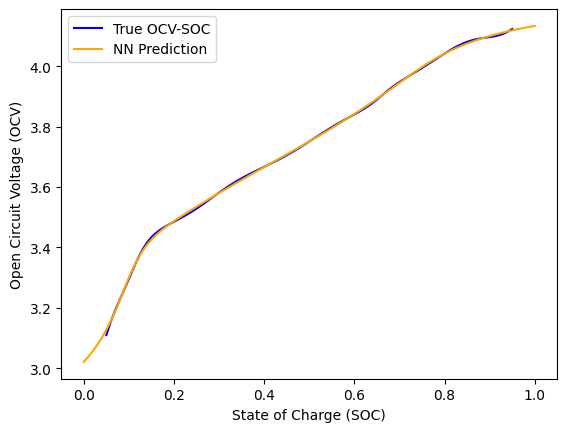

In [149]:
xplot = np.linspace(0, 1, 100)
xnorm = (torch.FloatTensor(xplot.reshape(-1,1)) - soc_mean) / soc_std
yplot = train_model(xnorm).detach()
yplot = (yplot * ocv_std + ocv_mean).numpy()

plt.plot(soc_vals, ocv_vals, label='True OCV-SOC', c='blue')
plt.plot(xplot, yplot, label='NN Prediction', c='orange')
plt.xlabel('State of Charge (SOC)')
plt.ylabel('Open Circuit Voltage (OCV)')
plt.legend()
plt.show()
